# An XGBoost Model for Classifing Quantitative Text

In this notebook, which should be read as a continuation of the multinomial naive bayes notebook in this project, we will be training an XGBoost model to classify academic papers into quantitative fields.

XGBoost is a regularized, gradient boosted, decision tree model. After making an initial tree, XGBoost creates further decision trees to account for the misclassifications of previous decision trees. The votes of these trees are scaled by a learning rate, and the ensemble of these trees making a decision together creates a model which is much less likely to overfit training data than a single decision tree. There are a large number of hyperparameters to tune which will explore through a grid search in this notebook.

## Importing and further processing the data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

PATH = 'sampledPapers.pickle'

We will combine the words which appear in the title and abstract into a single bag of words. In this notebook, we will again be aiming to predict the 'primary' column and so we drop the more fine grained 'categories' column.

In [2]:
df = pd.read_pickle(PATH)
df['title_and_abstract'] = df.apply(lambda row: row['title'] + ' ' + row['abstract'], axis=1)
df.drop(['title', 'abstract', 'categories'], axis=1, inplace=True)

We next split the data into features and target and vectorize the words appearing in the feature dataframe. 

In [3]:
X_train, X_test = train_test_split(df, train_size=0.8, stratify=df['primary'], random_state=100)
y_train, y_test = X_train['primary'], X_test['primary']
X_train.drop(labels=['primary'], axis=1, inplace=True)
X_test.drop(labels=['primary'], axis=1, inplace=True)

In order to have the hyperparameter optimization terminate in a reasonable amount of time, we will train the model on a vocabulary size of 10000.

In [4]:
vectorizor = ColumnTransformer([('title_and_abstract', CountVectorizer(stop_words='english', 
                                                            max_features=10000), 
                                                            'title_and_abstract')],
                                remainder='drop', verbose_feature_names_out=False)
X_train_vectorized = vectorizor.fit_transform(X_train)
X_test_vectorized = vectorizor.transform(X_test)


XGBoost works with encoded labels so we will need an assignment of classes to integers. We will use sklearn's LabelEncoder for this purpose. The label encoder will also learn an `inverse_trasform()` method which can help us interpret our model's predictions.

In [5]:
le = LabelEncoder()
le.fit(y_train)
y_train, y_test = le.transform(y_train),  le.transform(y_test)

## Training and tuning the XGBoost Model

### Training a baseline model

One of XGBoost's main desireable features is that, due to a number of under the hood optimizations, it works very well "out of the box." We expect this baseline model to not differ too signiifcantly from our optimized model.

In [6]:
clf = XGBClassifier()
clf.fit(X_train_vectorized, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [7]:
accuracy_score(y_test, clf.predict(X_test_vectorized))

0.7979344084073202

### Optimizing hyperparameters with a grid search

XGBoost has a large number of hyperparameters which can be tuned. In this notebook, we will focus on three of these parameters: the maximum depth of each tree, the learning rate, and the gamma parameter. Keeping the maximum depth of the trees below a certain length helps prevent overfitting. Similarly, the gamma parameter corresponds to the minimum loss reduction necessary in order to split a leaf in a tree, which can also prevent overfitting. The learning rate parameter plays a similar role as in other ML algorithms with larger values assisting in speed of fit, but risking overshooting local minima in loss functions.

Let's first set out our parameter grid. We will be tuning the XGBoost parameters `learning rate`, `max_depth`, and `gamma`.

In [8]:
params = {
        'learning_rate': [.1, .5, 1],
        'max_depth': [5, 6, 7],
        'gamma': [0, 0.25, 0.5]
        }
clf = XGBClassifier()
grid = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=3)

In [9]:
grid.fit(X_train_vectorized, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0, 0.25, 0.5],
                         'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 6, 7]},
             scoring='accuracy')

We have tuned three hyperparameters, and would like to plot the accuracy corresponding to each combination of the parameters. The complete graph would be four dimensional and difficult to interpret. Instead, we hold all of the parameters except one at the value of the best found estimator. We can then vary each hyperparameter individually to produce ordinary two dimensional plots for the accuracy. Below, we define the plotting subroutine for this. Thanks to [this stackoverflow answer](https://stackoverflow.com/a/57013458) for the implementation.

In [10]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='none',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

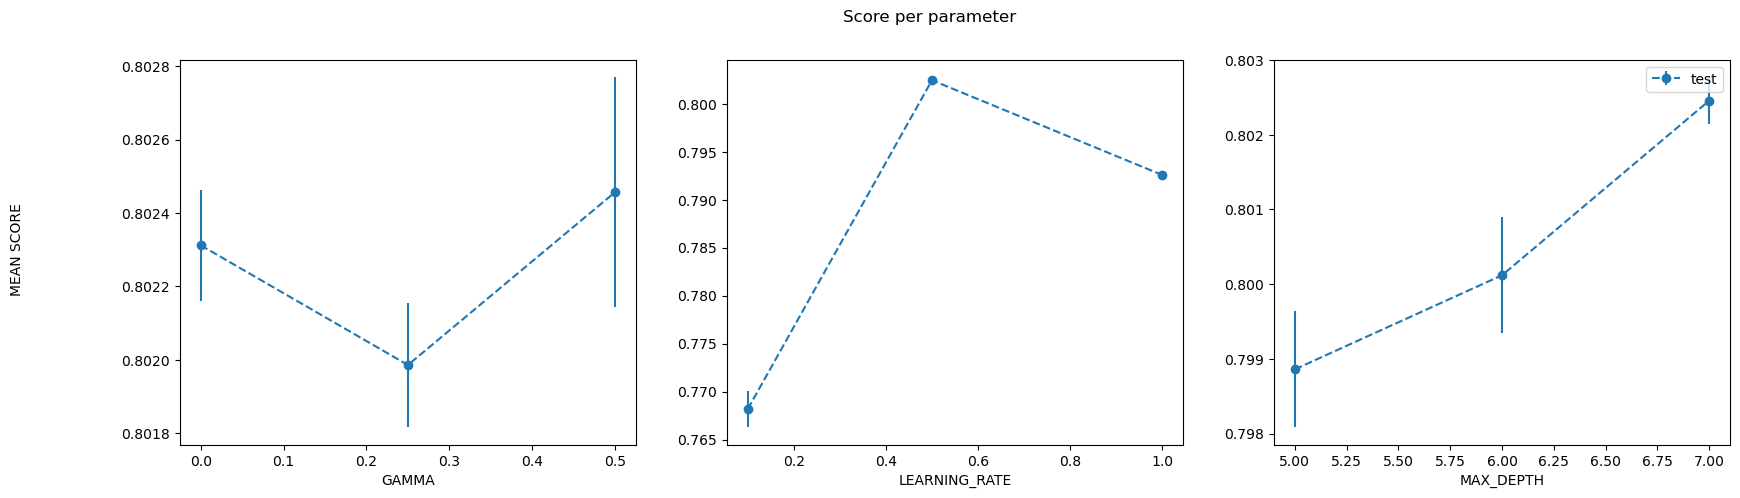

In [11]:
plot_search_results(grid)

As the gamma parameter and max depth of trees seem to not be having much of an impact, we can instead focus on tuning the learning rate. Let's still vary the max depth of the trees slightly as we do seem to be getting more accuracy. The accuracy of the model peaks at a learning rate somewhere near our tested value of $0.5$, so let's focus our search there.

In [12]:
params = {
        'learning_rate': [.3, .4, .5, .6, .7],
        'max_depth': [6, 7],
        'gamma' : [.5]
        }
clf = XGBClassifier()
grid = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=3)

In [13]:
grid.fit(X_train_vectorized, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0.5],
                         'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7],
                         'max_depth': [6, 7]},
             scoring='accuracy')

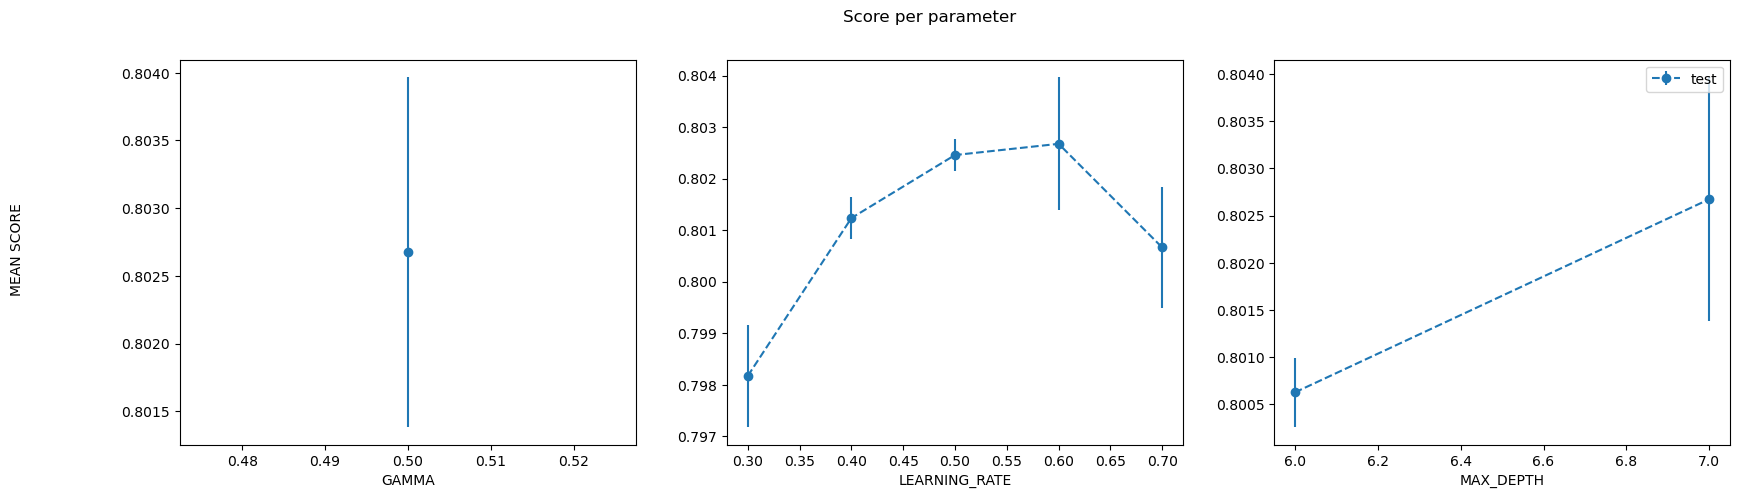

In [14]:
plot_search_results(grid)

We now see a clear peak for the learning rate somwehre between $0.5$ and $0.6$ with a negligeable difference in accuracy between the chosen values.

## Evaluating and exporting the final model

We have found that within our search, the optimal value for the `learning rate` is $0.6$, the `gamma` value is $0.5$, and the max depth is `max_depth` 7. Let's pull out this model from our grid of models, and find the accuracy score.

In [15]:
final_model = grid.best_estimator_
accuracy_score(final_model.predict(X_test_vectorized), y_test)

0.8071389744518934

Let's also plot the confusion matrix of this XGBoost model, and see if it looks significantly different from the confusion matrix of our naive Bayes model.

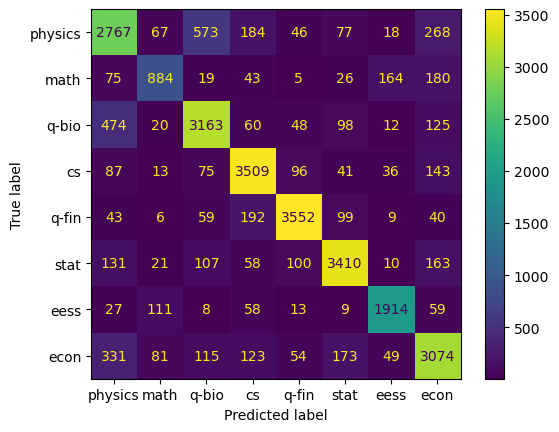

In [16]:
y_pred = final_model.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['physics', 'math', 'q-bio', 'cs', 'q-fin', 'stat', 'eess', 'econ'])
disp.plot()
plt.show()

The XGBoost model makes many of the same misclassifications as the previously trained naive Bayes model. This means that an ensemble of these techniques is unlikely to be helpful, and that the misclassifications are arising as an inherant closeness of the fields. Let's export this final model.

In [18]:
import joblib
joblib.dump(final_model, "Models/XGBQuantitativeClassifier")

['Models/XGBQuantitativeClassifier']

In the end, both of these models have their advantages. On one hand the multinomial naive bayes model is quite simple conceptually, and produces highly interpretable probabilities for class membership. On the other hand, the XGBoost model achieved similar results with a smaller vocabulary size, and ended up being much smaller in terms of space.